### Figure 4 | Sarcoidosis is characterized by a stable inflammatory baseline that is modulated but not normalized by vaccination
Baseline differential expression and longitudinal gene expression trajectories highlight persistent inflammatory programs across vaccination.

# Figure 4a

In [2]:
suppressPackageStartupMessages({
  library(DESeq2)
  library(SummarizedExperiment)
  library(dplyr)
  library(tidyr)
  library(ggplot2)
  library(readr)
  library(stringr)
  library(S4Vectors)
  library(tibble)
  library(dplyr)
  library(AnnotationDbi)
  library(org.Hs.eg.db)
  library(glue)
})


set.seed(42)

SCRIPT_REL_PATH <- NULL

if (is.null(SCRIPT_REL_PATH)) {
  # Interactive / notebook fallback: do not error, but warn if here() looks wrong
  if (!file.exists(here::here("README.md")) && !dir.exists(here::here(".git"))) {
    warning(
      "Repo root not detected via here(). ",
      "If paths are wrong, set your working directory to the repo root OR set SCRIPT_REL_PATH."
    )
  }
} else {
  here::i_am(SCRIPT_REL_PATH)
}

# ----------------------------
# Inputs
# ----------------------------
DATA_ROOT <- Sys.getenv("SARC_DATA_ROOT")

if (DATA_ROOT == "") {
  # sensible default for your setup; change if needed
  DATA_ROOT <- "/mnt/z"
  Sys.setenv(SARC_DATA_ROOT = DATA_ROOT)
  message("SARC_DATA_ROOT was not set; using: ", DATA_ROOT)
}

if (!dir.exists(DATA_ROOT)) stop(glue("DATA_ROOT not found: {DATA_ROOT}"), call. = FALSE)
SE_RDS <- file.path(DATA_ROOT, "se_all_final.rds")
if (!file.exists(SE_RDS)) stop(glue("Missing input file: {SE_RDS}"), call. = FALSE)
se <- readRDS(SE_RDS)

bundle <- readRDS(here::here("data", "derived", "fig_inputs_umap_vst_top1000_hc_sarc.rds"))
mat_top <- bundle$mat_top
df_hc   <- bundle$df_hc
cd      <- bundle$cd

## =========================
## Baseline: V1D0 (HC vs SX)
## =========================
stopifnot(exists("se"), is(se, "SummarizedExperiment"))

cd_all <- as.data.frame(colData(se))

# ---------- 0) Helpers ----------
# Map ENSG -> SYMBOL; return "" for unmapped
ens2sym <- function(ids) {
  ids2 <- sub("\\.\\d+$","", ids)

  m <- suppressWarnings(
    AnnotationDbi::mapIds(
      org.Hs.eg.db,
      keys      = unique(ids2),
      keytype   = "ENSEMBL",
      column    = "SYMBOL",
      multiVals = "first"
    )
  )

  sym <- unname(m[ids2])
  sym[is.na(sym)] <- ""
  sym
}

# Sarcoidosis / PBMC genes to prioritize in labels
sarcoid_label_genes <- c(
  # Core IFN / chemokine axis
  "STAT1","CXCL9","CXCL10","CXCL11",
  "GBP1","GBP5","IFIT3","IFI44","RTP4",
  # SARDS signature genes
  "LHFPL2","LEF1","LRRN3","CD27","EPHX2",
  # PBMC / BAL biology that may show up in blood
  "CCR5","IL7R","IL15",
  # Additional IFN / ISGs
  "IRF1","IRF7","ISG15","OAS1","OAS2","OASL","TNFSF10",
  # Chemokines / receptors
  "CCL2","CX3CR1",
  # Antigen presentation / DC machinery
  "HLA-DRA","HLA-DRB1","HLA-DQB1","CD74",
  # Myeloid / PRR genes
  "MARCO","TLR2","TLR4","TLR8","SOD2", "G6PD"
)

# Always label these NK genes if present
nk_force_genes <- character(0)

# Labels to explicitly suppress even if they would otherwise be chosen
exclude_labels <- c("RRAD","JUND","CASP8AP2","LRIF1", "DARS2","SNHG8","DHCR7-DT","DDX24")

# ---------- 1) Subset to V1D0 ----------
cd0 <- as.data.frame(colData(se))
tp_char <- NULL
if ("m_time_point" %in% names(cd0)) tp_char <- as.character(cd0$m_time_point)
if (is.null(tp_char) && "m_timepoint" %in% names(cd0)) tp_char <- as.character(cd0$m_timepoint)
if (is.null(tp_char)) {
  src <- if ("sample_id" %in% names(cd0)) cd0$sample_id else colnames(se)
  tp_char <- stringr::str_extract(src, "V[12]D\\d+")
}
stopifnot(!all(is.na(tp_char)))

keep_v1d0 <- !is.na(tp_char) & tp_char == "V1D0"
se_v1d0 <- se[, keep_v1d0, drop = FALSE]
if (ncol(se_v1d0) < 4) stop("Too few samples at V1D0 after filtering.")

cd_v1d0 <- as.data.frame(colData(se_v1d0))

# ---------- 2) Build group (HC vs SX) from 'm_group' ----------
cd <- as.data.frame(colData(se_v1d0))
if (!"m_group" %in% names(cd)) stop("'m_group' not found in colData(se).")

grp_raw <- toupper(as.character(cd$m_group))
grp_raw[grp_raw %in% c("SX","SARC","SARCOID","SARCOIDOSIS","SX?")] <- "SX"
grp_raw[grp_raw %in% c("HC","HEALTHY","HEALTHY CONTROL","CONTROL","HC?")] <- "HC"

keep_grp <- !is.na(grp_raw) & grp_raw %in% c("HC","SX")
se_v1d0 <- se_v1d0[, keep_grp, drop = FALSE]

cd <- as.data.frame(colData(se_v1d0))
grp <- toupper(as.character(cd$m_group))
grp[grp %in% c("SX","SARC","SARCOID","SARCOIDOSIS","SX?")] <- "SX"
grp[grp %in% c("HC","HEALTHY","HEALTHY CONTROL","CONTROL","HC?")] <- "HC"
cd$g <- factor(grp, levels = c("HC","SX"))

if (nlevels(cd$g) < 2 || any(table(cd$g) < 2))
  stop("Need at least 2 samples per group (HC and SX) at V1D0.")

row.names(cd) <- colnames(se_v1d0)
colData(se_v1d0) <- S4Vectors::DataFrame(cd)

message("Group sizes at V1D0:")
print(table(cd$g))

# ---------- 3) Ensure integer counts for DESeq2 (exclude rRNA) ----------
stopifnot("counts" %in% assayNames(se_v1d0))
cts <- assay(se_v1d0, "counts")
if (!is.matrix(cts)) cts <- as.matrix(cts)
cts[!is.finite(cts)] <- 0
cts <- round(cts)
storage.mode(cts) <- "integer"

# Identify ribosomal RNA genes
rd <- as.data.frame(rowData(se_v1d0))

# Start with all FALSE
is_ribo <- rep(FALSE, nrow(se_v1d0))

# 1) Prefer annotation if available
biotype_cols <- intersect(
  c("gene_biotype", "biotype", "Gene_Biotype", "gene_type"),
  colnames(rd)
)
if (length(biotype_cols) > 0) {
  bt <- rd[[biotype_cols[1]]]
  is_ribo <- is_ribo | bt %in% c(
    "rRNA", "Mt_rRNA", "rRNA_pseudogene",
    "Mt_rRNA_pseudogene", "rRNA_gene"
  )
}

# 2) Fallback: symbol-based heuristics
sym_all <- ens2sym(rownames(se_v1d0))
is_ribo <- is_ribo |
  grepl("^RPL[0-9]",  sym_all) |   # large cytosolic ribosomal proteins
  grepl("^RPS[0-9]",  sym_all) |   # small cytosolic ribosomal proteins
  grepl("^MRPL[0-9]", sym_all) |   # mitochondrial large subunit
  grepl("^MRPS[0-9]", sym_all) |   # mitochondrial small subunit
  grepl("^RNA1[68]S", sym_all) |   # 16S/18S rRNA-style names
  grepl("^RNA28S",    sym_all)     # 28S rRNA-style names

message("Excluding ", sum(is_ribo), " ribosomal RNA genes before DESeq2.")

# Drop rRNA genes from counts & SE
cts       <- cts[!is_ribo, , drop = FALSE]
se_v1d0   <- se_v1d0[!is_ribo, ]

# (optional but recommended) prefilter very low count genes
keep_genes <- rowSums(cts) >= 10
cts       <- cts[keep_genes, , drop = FALSE]
se_v1d0   <- se_v1d0[keep_genes, ]


# ---------- helper to silence only nbinomGLM "line search" warnings ----------
suppress_nbinom_warnings <- function(expr) {
  withCallingHandlers(
    expr,
    warning = function(w) {
      msg <- conditionMessage(w)
      if (grepl("the line search routine failed", msg)) {
        invokeRestart("muffleWarning")
      }
    }
  )
}

# ---------- 4) Build and run DESeq2 ----------
dds_v1d0 <- DESeqDataSetFromMatrix(
  countData = cts,
  colData   = colData(se_v1d0),
  design    = ~ g
)

dds_v1d0 <- suppress_nbinom_warnings(
  DESeq(dds_v1d0, parallel = FALSE)
)

rn <- resultsNames(dds_v1d0)
coef_name <- if ("g_SX_vs_HC" %in% rn) "g_SX_vs_HC" else {
  cand <- rn[grepl("^g_.*_vs_.*$", rn)]
  if (length(cand) == 0) stop("Could not find a g_* contrast in resultsNames(). Names were: ", paste(rn, collapse=", "))
  cand[1]
}

## Full (unshrunken) results for tables and ranking
res_raw <- suppress_nbinom_warnings(
  results(dds_v1d0, name = coef_name, alpha = 0.05)
)

## Shrunken LFCs for plotting
res_shrunk <- suppress_nbinom_warnings(
  lfcShrink(dds_v1d0, coef = coef_name, type = "apeglm")
)

## Convenience objects
res <- res_shrunk
res_v1d0     <- res_shrunk
res_v1d0_raw <- res_raw

# ---------- 5) Tidy + save (using raw LFCs in the CSV) ----------
tab <- as.data.frame(res_raw)
tab$gene_id <- rownames(dds_v1d0)
tab$symbol  <- ens2sym(rownames(dds_v1d0))
# For CSV only, fall back to gene_id if symbol is blank
idx_blank <- tab$symbol == ""
tab$symbol[idx_blank] <- tab$gene_id[idx_blank]


tab <- tab %>%
  dplyr::select(symbol, gene_id, log2FoldChange, lfcSE, stat, pvalue, padj) %>%
  dplyr::arrange(pvalue)

DATA_DIR <- here::here("data", "derived")
dir.create(DATA_DIR, recursive = TRUE, showWarnings = FALSE)
saveRDS(dds_v1d0, file.path(DATA_DIR, "dds_v1d0_HC_vs_SX.rds"))

TAB_DIR <- here::here("tables", "main")
dir.create(TAB_DIR, recursive = TRUE, showWarnings = FALSE)
readr::write_csv(tab, file.path(TAB_DIR, "DIAG_SX_vs_HC_at_V1D0.csv"))

# print(utils::head(tab, 12))

## ============================================================
## 6) Volcano plot (using shrunken LFCs, capped axes)
## ============================================================

padj_thr <- 0.05
lfc_thr  <- 1

y_cap <- 10    # cap -log10(FDR)
xmax  <- 5     # x axis range

df <- as.data.frame(res)   # shrunken LFCs
df$gene_id <- rownames(df)
df$symbol  <- ens2sym(rownames(df))

volc <- df %>%
  dplyr::mutate(
    neglog10padj_raw = -log10(padj),
    neglog10padj     = pmin(neglog10padj_raw, y_cap),
    cls = dplyr::case_when(
      is.finite(padj) & padj < padj_thr & log2FoldChange >=  lfc_thr ~ "Up",
      is.finite(padj) & padj < padj_thr & log2FoldChange <= -lfc_thr ~ "Down",
      TRUE ~ "NS"
    )
  ) %>%
  dplyr::filter(is.finite(log2FoldChange), is.finite(neglog10padj))

n_up <- sum(volc$cls == "Up",   na.rm = TRUE)
n_dn <- sum(volc$cls == "Down", na.rm = TRUE)
leg_labs <- c(
  Up   = paste0("Up (", n_up, ") in Sarcoidosis"),
  Down = paste0("Down (", n_dn, ") in Sarcoidosis"),
  NS   = "NS"
)

# Sarcoid genes actually present
sarcoid_label_genes_present <- intersect(sarcoid_label_genes, unique(volc$symbol))

# Sarcoid/NK genes: require significance, no LFC cutoff
sarcoid_lab <- volc %>%
  dplyr::filter(
    symbol %in% sarcoid_label_genes_present |
      symbol %in% nk_force_genes
  ) %>%
  dplyr::filter(is.finite(padj) & padj < padj_thr)

# Other DEGs: require significance AND |LFC| >= 1
top_other_up <- volc %>%
  dplyr::filter(
    cls == "Up",
    is.finite(padj), padj < padj_thr,
    abs(log2FoldChange) >= lfc_thr
  ) %>%
  dplyr::filter(!(symbol %in% c(sarcoid_label_genes_present, nk_force_genes))) %>%
  dplyr::arrange(padj) %>%
  dplyr::slice_head(n = 3)

top_other_down <- volc %>%
  dplyr::filter(
    cls == "Down",
    is.finite(padj), padj < padj_thr,
    abs(log2FoldChange) >= lfc_thr
  ) %>%
  dplyr::filter(!(symbol %in% c(sarcoid_label_genes_present, nk_force_genes))) %>%
  dplyr::arrange(padj) %>%
  dplyr::slice_head(n = 3)

# Additional genes with the largest |LFC|, still requiring significance and |LFC| >= 1
high_lfc_up <- volc %>%
  dplyr::filter(
    cls == "Up",
    is.finite(padj), padj < padj_thr,
    abs(log2FoldChange) >= lfc_thr
  ) %>%
  dplyr::filter(!(symbol %in% c(sarcoid_label_genes_present, nk_force_genes))) %>%
  dplyr::arrange(dplyr::desc(abs(log2FoldChange))) %>%
  dplyr::slice_head(n = 3)

high_lfc_down <- volc %>%
  dplyr::filter(
    cls == "Down",
    is.finite(padj), padj < padj_thr,
    abs(log2FoldChange) >= lfc_thr
  ) %>%
  dplyr::filter(!(symbol %in% c(sarcoid_label_genes_present, nk_force_genes))) %>%
  dplyr::arrange(dplyr::desc(abs(log2FoldChange))) %>%
  dplyr::slice_head(n = 3)

# Combine and clean: this enforces significance for *all* labels,
# and |LFC| >= 1 for non-prior genes.
lab_df <- dplyr::bind_rows(
    sarcoid_lab,
    top_other_up,
    top_other_down,
    high_lfc_up,
    high_lfc_down
  ) %>%
  dplyr::distinct(symbol, .keep_all = TRUE) %>%
  dplyr::filter(
    is.finite(padj), padj < padj_thr,
    !is.na(symbol),
    symbol != "",
    !grepl("ENSG", symbol),
    !(symbol %in% exclude_labels)
  )


xb <- c(-xmax, -lfc_thr, 0, lfc_thr, xmax)
pal <- c("Down" = "#0072B2", "NS" = "grey78", "Up" = "#D55E00")

# ====== Supplementary dispersion plot ======
# Save figure
SUPP_FIG_DIR <- here::here("figures", "supplementary")
dir.create(SUPP_FIG_DIR, recursive = TRUE, showWarnings = FALSE)
pdf(file.path(SUPP_FIG_DIR, "dispersion_V1D0_dds_v1d0.pdf"), width = 5, height = 4)
plotDispEsts(dds_v1d0)
dev.off()

png(  file.path(SUPP_FIG_DIR, "dispersion_V1D0_dds_v1d0.png"), width = 5, height = 4, units = "in", res = 300)
plotDispEsts(dds_v1d0)
dev.off()
# ========================================

## ============================================================
## Volcano plot: SARC vs HC at V1D0 with curated + extreme labels
## ============================================================

padj_thr <- 0.05
lfc_thr  <- 1

y_cap <- 10       # cap for -log10 FDR on the y-axis
xmax  <- 5        # x-axis limit

# Curated sarcoid / NK genes
sarcoid_label_genes <- c(
  # Core IFN / chemokine axis
  "STAT1","CXCL9","CXCL10","CXCL11",
  "GBP1","GBP5","IFIT3","IFI44","RTP4",
  # SARDS signature genes
  "LHFPL2","LEF1","LRRN3","CD27","EPHX2",
  # PBMC / BAL biology that may show up in blood
  "CCR5","IL7R","IL15",
  # Additional IFN / ISGs
  "IRF1","IRF7","OAS1","OAS2","OASL","TNFSF10",
  # Chemokines / receptors
  "CCL2","CX3CR1",
  # Antigen presentation / DC machinery
  "HLA-DRA","HLA-DQB1","CD74",
  # Myeloid / PRR genes
  "MARCO","TLR2","TLR4","G6PD"
)

# nk_force_genes <- c("KIR3DL1","KIR3DL2")

exclude_labels <- c(
  "RRAD","JUND","CASP8AP2","LRIF1",
  "DARS2","SNHG8","DHCR7-DT","DDX24", 
  "SNHG1", "CARD6", "KIR3DL1","KIR3DL2",
  "CPSF2", "TLR8"
)

# How many curated and extreme labels to keep
n_curated      <- 8   # number of curated sarcoid/NK genes
n_extreme_up   <- 12   # top-k extreme Up
n_extreme_down <- 12   # top-k extreme Down

# Optional: extra genes you ALWAYS want labeled if significant
force_genes <- c(
  # e.g. "CXCL9"
)

# ---- Build plotting dataframe from shrunken results ----
df <- as.data.frame(res_shrunk)
df$gene_id <- rownames(df)
df$symbol  <- ens2sym(rownames(df))

volc <- df %>%
  dplyr::mutate(
    neglog10padj_raw = -log10(padj),
    neglog10padj     = pmin(neglog10padj_raw, y_cap),
    cls = dplyr::case_when(
      is.finite(padj) & padj < padj_thr & log2FoldChange >=  lfc_thr ~ "Up",
      is.finite(padj) & padj < padj_thr & log2FoldChange <= -lfc_thr ~ "Down",
      TRUE ~ "NS"
    )
  ) %>%
  dplyr::filter(
    is.finite(log2FoldChange),
    is.finite(neglog10padj)
  )

# ---- Legend labels ----
n_up <- sum(volc$cls == "Up",   na.rm = TRUE)
n_dn <- sum(volc$cls == "Down", na.rm = TRUE)
leg_labs <- c(
  Up   = paste0("Up (", n_up, ") in Sarcoidosis"),
  Down = paste0("Down (", n_dn, ") in Sarcoidosis"),
  NS   = "NS"
)

# ------------------------------------------------------------
# Choose labels
# ------------------------------------------------------------

# 1) Curated sarcoid / NK genes that are significant
sarcoid_label_genes_present <- intersect(sarcoid_label_genes, unique(volc$symbol))

sarcoid_lab_all <- volc %>%
  dplyr::filter(
    symbol %in% sarcoid_label_genes_present |
      symbol %in% nk_force_genes
  ) %>%
  dplyr::filter(is.finite(padj) & padj < padj_thr)

# Limit to the top N curated genes by FDR (most strongly supported)
sarcoid_lab <- sarcoid_lab_all %>%
  dplyr::arrange(padj) %>%
  dplyr::slice_head(n = n_curated)

# 2) Extreme Up / Down genes by distance from origin in (log2FC, -log10 FDR) space

# Up-regulated in SARC
volc_sig_up <- volc %>%
  dplyr::filter(
    cls == "Up",
    is.finite(padj), padj < padj_thr
  ) %>%
  dplyr::mutate(
    neglog10padj_raw = -log10(padj),
    dist2 = log2FoldChange^2 + neglog10padj_raw^2
  )

# Down-regulated in SARC
volc_sig_down <- volc %>%
  dplyr::filter(
    cls == "Down",
    is.finite(padj), padj < padj_thr
  ) %>%
  dplyr::mutate(
    neglog10padj_raw = -log10(padj),
    dist2 = log2FoldChange^2 + neglog10padj_raw^2
  )

exclude_curated <- c(sarcoid_lab$symbol, nk_force_genes)

extreme_up <- volc_sig_up %>%
  dplyr::filter(!(symbol %in% exclude_curated)) %>%
  dplyr::arrange(dplyr::desc(dist2)) %>%
  dplyr::slice_head(n = n_extreme_up)

extreme_down <- volc_sig_down %>%
  dplyr::filter(!(symbol %in% exclude_curated)) %>%
  dplyr::arrange(dplyr::desc(dist2)) %>%
  dplyr::slice_head(n = n_extreme_down)

# 3) Forced extra genes (if significant)
force_lab <- volc %>%
  dplyr::filter(
    symbol %in% force_genes,
    is.finite(padj), padj < padj_thr
  )

# 4) Combine labels and clean
lab_df <- dplyr::bind_rows(
    sarcoid_lab,
    extreme_up,
    extreme_down,
    force_lab
  ) %>%
  dplyr::distinct(symbol, .keep_all = TRUE) %>%
  dplyr::filter(
    !is.na(symbol),
    symbol != "",
    !grepl("ENSG", symbol),
    !(symbol %in% exclude_labels)
  )

# Quick sanity check: what are we labeling?
message("Number of labels: ", nrow(lab_df))
print(
  lab_df %>%
    dplyr::select(symbol, log2FoldChange, padj, cls) %>%
    dplyr::arrange(padj)
)

# ------------------------------------------------------------
# Plot
# ------------------------------------------------------------

xb  <- c(-xmax, -lfc_thr, 0, lfc_thr, xmax)
pal <- c("Down" = "#0072B2", "NS" = "grey78", "Up" = "#D55E00")

g_volc_final <- ggplot(volc, aes(x = log2FoldChange, y = neglog10padj)) +
  geom_point(
    aes(
      color = cls,
      alpha = ifelse(cls == "NS", 0.25, 0.85)
    ),
    size = 2.6
  ) +
  scale_alpha_identity(guide = "none") +
  scale_color_manual(
    values = pal,
    labels = leg_labs,
    breaks = c("Up","Down","NS"),
    name   = "Significant genes"
  ) +
  geom_hline(yintercept = -log10(padj_thr), linetype = 2, linewidth = 0.4) +
  geom_vline(xintercept = c(-lfc_thr, lfc_thr), linetype = 2, linewidth = 0.4) +
  annotate(
    "text", x = xmax, y = -log10(padj_thr) + 0.3,
    label = paste0("FDR < ", padj_thr),
    hjust = 1, vjust = 0, size = 4.6, color = "grey20"
  ) +
  annotate(
    "text", x =  lfc_thr + 0.15, y = 0.2,
    label = paste0("+|LFC| >= ", lfc_thr),
    hjust = 0, vjust = 0, size = 4.6, color = "grey20"
  ) +
  annotate(
    "text", x = -lfc_thr - 0.15, y = 0.2,
    label = paste0("-|LFC| >= ", lfc_thr),
    hjust = 1, vjust = 0, size = 4.6, color = "grey20"
  ) +
  ggrepel::geom_text_repel(
    data = lab_df,
    aes(
      label = symbol,
      fontface = ifelse(
        symbol %in% c(sarcoid_label_genes_present, nk_force_genes),
        "bold", "plain"
      )
    ),
    size = 5.9,
    box.padding = 0.4,
    point.padding = 0.3,
    min.segment.length = 0,
    segment.size = 0.4,
    segment.alpha = 0.6,
    max.overlaps = Inf,
    force = 1.2,
    seed = 42
  ) +
  scale_y_continuous(
    limits = c(0, y_cap),
    breaks = c(0, 2, 4, 6, 8, 10),
    labels = function(x) ifelse(x == y_cap, paste0("≥", y_cap), x),
    expand = expansion(mult = c(0, 0.03))
  ) +
  scale_x_continuous(
    limits = c(-xmax, xmax),
    breaks = xb,
    expand = expansion(mult = c(0.02, 0.02))
  ) +
  labs(
    x = "log2 fold change (SARC / HC)",
    y = expression(-log[10]~FDR)
  ) +
  theme_bw(base_size = 14) +
  theme(
    panel.grid = element_blank(),
    axis.title = element_text(size = 14),
    axis.text  = element_text(size = 14),
    legend.position      = c(0.57, 0.6),
    legend.title         = element_text(size = 18, face = "bold"),
    legend.text          = element_text(size = 18),
    legend.justification = c("right", "top"),
    legend.background    = element_rect(
      fill  = scales::alpha("white", 0.85),
      color = "grey80"
    ),
    legend.key.width     = unit(10, "pt")
  )
  

# Save figure
FIG_DIR <- here::here("figures", "main")
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)
    
ggsave(
  file.path(FIG_DIR, "Fig4a_volcano_V1D0_SX_vs_HC.pdf"),
  g_volc_final, width = 10, height = 8, useDingbats = FALSE
)
ggsave(
  file.path(FIG_DIR, "Fig4a_volcano_V1D0_SX_vs_HC.png"),
  g_volc_final, width = 10, height = 8, dpi = 750
)

dev.off()


SARC_DATA_ROOT was not set; using: /mnt/z

Group sizes at V1D0:




HC SX 
19 10 


'select()' returned 1:many mapping between keys and columns

Excluding 1533 ribosomal RNA genes before DESeq2.

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1033 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

using 'apeglm' for LFC shrinkage. If used in published research, please cite:
    Zhu, A., Ibrahim, J.G., Love, M.I. (2018) Heavy-tailed prior distributions for
    sequence count data: removing the noise and preserving large differences.
    Bioinformatics. https://doi.org/10.1093/bioinformatics/bty895

'select()' returned 1:many mapping between keys and columns

'select()' returned 1:many mapping between keys and columns



pdf 
  2

pdf 
  2

'select()' returned 1:many mapping between keys and columns

Number of labels: 16



                 symbol log2FoldChange         padj  cls
ENSG00000112511    PHF1     -2.0033724 7.657225e-11 Down
ENSG00000072310  SREBF1     -1.2855320 6.523578e-10 Down
ENSG00000154358   OBSCN     -1.2087497 6.864136e-10 Down
ENSG00000132661    NXT1     -1.2671352 1.334608e-09 Down
ENSG00000142798   HSPG2     -1.4889764 2.522947e-09 Down
ENSG00000134198  TSPAN2      1.1200875 5.995197e-08   Up
ENSG00000196542  SPTSSB      2.5500255 7.859473e-08   Up
ENSG00000168329  CX3CR1      2.1205495 1.314900e-07   Up
ENSG00000198876  DCAF12      1.5599056 1.357771e-07   Up
ENSG00000139679   LPAR6      1.1934117 1.526018e-07   Up
ENSG00000198924 DCLRE1A      1.1221725 2.002814e-07   Up
ENSG00000134539   KLRD1      1.3947562 3.586965e-07   Up
ENSG00000138795    LEF1     -0.6503281 3.493478e-04   NS
ENSG00000121858 TNFSF10      1.0434468 3.187276e-03   Up
ENSG00000160791    CCR5      0.6515730 6.385791e-03   NS
ENSG00000089127    OAS1      0.8017779 1.818516e-02   NS


Warning message in grid.Call.graphics(C_text, as.graphicsAnnot(x$label), x$x, x$y, :
“for '≥10' in 'mbcsToSbcs': >= substituted for ≥ (U+2265)”


null device 
          1

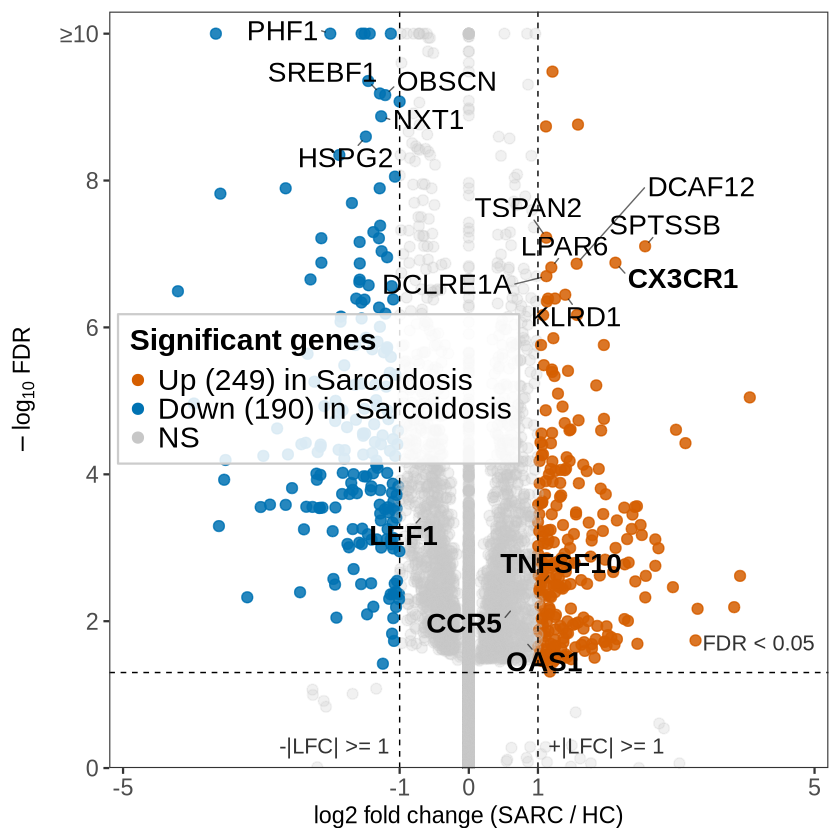

In [3]:
print(g_volc_final)

# Figure 4b

In [4]:
############################################################
## 0) Setup
############################################################
suppressPackageStartupMessages({
  library(DESeq2)
  library(dplyr)
  library(tidyr)
  library(readr)
  library(stringr)
  library(ggplot2)
  library(ggrepel)
  library(fgsea)
  library(msigdbr)
  library(tidyverse)
  library(data.table)
  library(AnnotationDbi)
  library(ComplexHeatmap)
  library(circlize)
  library(SummarizedExperiment)
  library(BiocParallel)
  library(org.Hs.eg.db)
  library(matrixStats)
  library(pheatmap)
  library(grid)
})

if (.Platform$OS.type == "windows") {
  BiocParallel::register(
    BiocParallel::SnowParam(workers = max(1, parallel::detectCores() - 1))
  )
} else {
  BiocParallel::register(
    BiocParallel::MulticoreParam(workers = max(1, parallel::detectCores() - 1))
  )
}
set.seed(42)

SCRIPT_REL_PATH <- NULL

if (is.null(SCRIPT_REL_PATH)) {
  # Interactive / notebook fallback: do not error, but warn if here() looks wrong
  if (!file.exists(here::here("README.md")) && !dir.exists(here::here(".git"))) {
    warning(
      "Repo root not detected via here(). ",
      "If paths are wrong, set your working directory to the repo root OR set SCRIPT_REL_PATH."
    )
  }
} else {
  here::i_am(SCRIPT_REL_PATH)
}

# ----------------------------
# Inputs
# ----------------------------
DATA_ROOT <- Sys.getenv("SARC_DATA_ROOT")

if (DATA_ROOT == "") {
  # sensible default for your setup; change if needed
  DATA_ROOT <- "/mnt/z"
  Sys.setenv(SARC_DATA_ROOT = DATA_ROOT)
  message("SARC_DATA_ROOT was not set; using: ", DATA_ROOT)
}

# NOTE USES THE PAIRED ALL TIMEPOINTS SE FOR CONSISTENCY
if (!dir.exists(DATA_ROOT)) stop(glue("DATA_ROOT not found: {DATA_ROOT}"), call. = FALSE)
SE_RDS <- file.path(DATA_ROOT, "se_paired_all_timepoints.rds")
if (!file.exists(SE_RDS)) stop(glue("Missing input file: {SE_RDS}"), call. = FALSE)
se_all_full <- readRDS(SE_RDS)

cd <- as.data.frame(colData(se_all_full))

############################################################
## 1) Config and helpers
############################################################
visits      <- c("V1D0","V1D7","V2D0","V2D7")
top_n_each  <- 50
padj_thr    <- 0.05
exclude_pat <- "^(RPL|RPS|MRPL|MRPS)"   # exclude ribosomal-like for plotting

`%||%` <- function(a, b) if (is.null(a)) b else a

is_ENSG_like <- function(x) {
  grepl("^ENS[A-Z]*[0-9]", x %||% "")
}

ens2sym <- function(ids) {
  ids2 <- sub("\\.\\d+$", "", ids)
  m <- AnnotationDbi::mapIds(
    org.Hs.eg.db,
    keys      = unique(ids2),
    keytype   = "ENSEMBL",
    column    = "SYMBOL",
    multiVals = "first"
  )
  sym <- unname(m[ids2])
  sym
}

.get_tp <- function(cd) {
  tp <- NULL
  if ("m_time_point" %in% names(cd)) tp <- as.character(cd$m_time_point)
  if (is.null(tp) && "m_timepoint" %in% names(cd)) tp <- as.character(cd$m_timepoint)
  if (is.null(tp)) {
    src <- if ("sample_id" %in% names(cd)) cd$sample_id else rownames(cd)
    tp <- stringr::str_extract(src, "V[12]D\\d+")
  }
  tp
}

.clean_group <- function(x) {
  x <- toupper(as.character(x))
  x[x %in% c("SX","SARC","SARCOID","SARCOIDOSIS","SX?")] <- "SX"
  x[x %in% c("HC","HEALTHY","HEALTHY CONTROL","CONTROL","HC?")] <- "HC"
  factor(x, levels = c("HC","SX"))
}

## lncRNA genes to mark with "*"
lnc_genes <- c(
  "MALAT1",
  "SNHG32",
  "TALAM1",
  "HCG18",
  "PSMB8-AS1",
  "NOTCH2NLC"
)

is_lnc_like <- function(g) {
  g <- as.character(g)
  g %in% lnc_genes |
    grepl("^LINC", g) |      # LINCxxxx
    grepl("AS[0-9]*$", g)    # antisense like PSMB8-AS1
}

## DESeq2 for a single visit
de_visit <- function(se, visit, padj_thr = 0.05) {
  cd <- as.data.frame(colData(se))
  tp <- .get_tp(cd)
  keep <- !is.na(tp) & tp == visit
  stopifnot(sum(keep) >= 4)

  se_v <- se[, keep, drop = FALSE]
  cdv  <- as.data.frame(colData(se_v))
  cdv$g <- .clean_group(cdv$m_group)
  if (any(table(cdv$g) < 2)) stop("Need ≥ 2 per group at ", visit)

  cts <- assay(se_v, "counts")
  cts[!is.finite(cts)] <- 0
  cts <- as.matrix(round(cts))
  storage.mode(cts) <- "integer"
  stopifnot(identical(colnames(cts), rownames(cdv)))

  dds <- DESeqDataSetFromMatrix(
    countData = cts,
    colData   = cdv,
    design    = ~ g
  )
  dds <- DESeq(dds, parallel = FALSE)

  rn <- resultsNames(dds)
  coef_name <- if ("g_SX_vs_HC" %in% rn) {
    "g_SX_vs_HC"
  } else {
    rn[grepl("^g_.*_vs_.*$", rn)][1]
  }

  res <- results(dds, name = coef_name, alpha = padj_thr)

  df <- as.data.frame(res)
  df$gene_id <- rownames(df)
  df$symbol  <- ens2sym(df$gene_id)

  df <- df %>%
    dplyr::select(gene_id, symbol, log2FC = log2FoldChange, padj) %>%
    dplyr::arrange(padj)

  list(dds = dds, de = df)
}

############################################################
## 2) DE per visit, union of top DEGs (non-ribosomal, non-ENSG)
############################################################
stopifnot(exists("se_all_full"), is(se_all_full, "SummarizedExperiment"))
stopifnot("counts" %in% assayNames(se_all_full))

union_ids <- character(0)
per_visit <- setNames(vector("list", length(visits)), visits)

for (v in visits) {
  out <- de_visit(se_all_full, v, padj_thr)
  per_visit[[v]] <- out

  de <- out$de %>%
    dplyr::filter(
      is.finite(padj),
      padj < padj_thr
    ) %>%
    dplyr::arrange(padj, dplyr::desc(abs(log2FC)))

  de <- de[
    !grepl(exclude_pat, de$symbol %||% "") &
      !is_ENSG_like(de$symbol),
    ,
    drop = FALSE
  ]

  union_ids <- unique(c(union_ids, head(de$gene_id, top_n_each)))
}
stopifnot(length(union_ids) > 0)

############################################################
## 3) VST and ΔVST (SX − HC) per visit
############################################################
cd_all   <- as.data.frame(colData(se_all_full))
tp_all   <- .get_tp(cd_all)
keep_all <- tp_all %in% visits
se_sub   <- se_all_full[, keep_all, drop = FALSE]

cts_all <- as.matrix(round(assay(se_sub, "counts")))
storage.mode(cts_all) <- "integer"

dds_all <- DESeqDataSetFromMatrix(
  countData = cts_all,
  colData   = colData(se_sub),
  design    = ~ 1
)

vsd <- vst(dds_all, blind = TRUE)

vst_mat <- assay(vsd)
vst_mat <- vst_mat[union_ids, , drop = FALSE]

syms <- ens2sym(rownames(vst_mat))
keep_sym <- !is.na(syms) & syms != "" & !is_ENSG_like(syms)
vst_mat  <- vst_mat[keep_sym, , drop = FALSE]
syms     <- syms[keep_sym]
rownames(vst_mat) <- syms

cd_sub          <- as.data.frame(colData(se_sub))
cd_sub$Visit    <- .get_tp(cd_sub)
cd_sub$Group    <- .clean_group(cd_sub$m_group)

visit_means <- lapply(visits, function(v) {
  idx_v  <- cd_sub$Visit == v
  sx_idx <- idx_v & cd_sub$Group == "SX"
  hc_idx <- idx_v & cd_sub$Group == "HC"
  stopifnot(sum(sx_idx) > 0, sum(hc_idx) > 0)
  rowMeans(vst_mat[, sx_idx, drop = FALSE]) -
    rowMeans(vst_mat[, hc_idx, drop = FALSE])
})
names(visit_means) <- visits

mat_delta <- do.call(cbind, visit_means)
mat_delta <- mat_delta[, visits, drop = FALSE]

############################################################
## 4) Union heatmap (optional, with clearer legend)
############################################################
mat_z <- t(scale(t(mat_delta)))
rownames(mat_z) <- rownames(mat_delta)
colnames(mat_z) <- visits

## mark lnc / noncoding with "*"
genes_union <- rownames(mat_z)
genes_union_marked <- ifelse(is_lnc_like(genes_union),
                             paste0(genes_union, "*"),
                             genes_union)
rownames(mat_z) <- genes_union_marked


col_fun <- colorRamp2(c(-2, 0, 2), c("#2166AC", "#F7F7F7", "#B2182B"))

## Column annotation (Dose and Day)
dose <- ifelse(grepl("^V1", colnames(mat_z)), "Dose 1", "Dose 2")
day  <- ifelse(grepl("D0$", colnames(mat_z)), "Day 0", "Day 7")

ha_cols <- list(
  Dose = c("Dose 1" = "#444444", "Dose 2" = "#AAAAAA"),
  Day  = c("Day 0"  = "#ffffff", "Day 7"  = "#cccccc")
)

top_anno_union <- HeatmapAnnotation(
  Dose = dose,
  Day  = day,
  col  = ha_cols,
  annotation_name_side = "left",
  simple_anno_size = unit(3.5, "mm")
)

ht_union <- Heatmap(
  mat_z,
  name = "legend",
  col  = col_fun,
  cluster_rows    = TRUE,
  cluster_columns = FALSE,
  top_annotation  = top_anno_union,
  column_names_side     = "top",
  column_names_rot      = 0,
  column_names_centered = TRUE,
  column_names_gp       = gpar(fontsize = 12, fontface = "bold"),
  row_names_gp          = gpar(fontsize = 9.5),
  row_names_max_width   = unit(65, "mm"),
  column_gap            = unit(4, "mm"),
  heatmap_legend_param = list(
    title = "ΔVST (SX − HC, row z)",
    legend_direction = "horizontal",
    at = c(-2, 0, 2),
    labels = c("-2", "0", "2"),
    title_gp  = gpar(fontface = "bold"),
    labels_gp = gpar(fontsize = 9)
  )
)

############################################################
## 5) Top-variance 50 heatmap, split by Up/Down at V1D0
############################################################
K <- 50
mat_ord <- mat_delta[, c("V1D0","V1D7","V2D0","V2D7"), drop = FALSE]

vars <- apply(mat_ord, 1, var, na.rm = TRUE)
top_idx <- order(vars, decreasing = TRUE)[seq_len(min(K, length(vars)))]
mat_top <- mat_ord[top_idx, , drop = FALSE]

mat_top_z <- t(scale(t(mat_top)))
rownames(mat_top_z) <- rownames(mat_top)
colnames(mat_top_z) <- c("V1D0","V1D7","V2D0","V2D7")

## Mark lnc / noncoding genes with "*"
genes <- rownames(mat_top_z)
genes_marked <- ifelse(is_lnc_like(genes),
                       paste0(genes, "*"),
                       genes)
rownames(mat_top_z) <- genes_marked


row_group <- ifelse(mat_top_z[, "V1D0"] >= 0, "Up at V1D0", "Down at V1D0")

## Column annotation for this matrix
dose_top <- ifelse(grepl("^V1", colnames(mat_top_z)), "Dose 1", "Dose 2")
day_top  <- ifelse(grepl("D0$", colnames(mat_top_z)), "Day 0", "Day 7")

top_anno_top50 <- HeatmapAnnotation(
  Dose = dose_top,
  Day  = day_top,
  col  = ha_cols,
  annotation_name_side = "left",
  simple_anno_size = unit(3.5, "mm")
)

col_fun2 <- colorRamp2(c(-2, 0, 2), c("#2166AC", "#F7F7F7", "#B2182B"))

ht_top50 <- Heatmap(
  mat_top_z,
  name = "legend",
  col  = col_fun2,
  cluster_rows    = TRUE,  # dendrograms retained within each split
  row_split       = factor(row_group,
                           levels = c("Up at V1D0", "Down at V1D0")),
  row_title_rot   = 0,
  cluster_columns = FALSE,
  top_annotation  = top_anno_top50,
  column_names_side     = "top",
  column_names_rot      = 0,
  column_names_centered = TRUE,
  column_names_gp       = gpar(fontsize = 14, fontface = "bold"),
  row_names_gp          = gpar(fontsize = 12),
  row_names_max_width   = unit(70, "mm"),
  column_gap            = unit(4, "mm"),
  heatmap_legend_param = list(
    title = "ΔVST (SX − HC, row z)",
    legend_direction = "horizontal",
    at = c(-2, 0, 2),
    labels = c("-2", "0", "2"),
    title_gp  = gpar(fontface = "bold"),
    labels_gp = gpar(fontsize = 10)
  )
)


# Save figure
FIG_DIR <- here::here("figures", "main")
dir.create(FIG_DIR, recursive = TRUE, showWarnings = FALSE)
    
pdf(file.path(FIG_DIR, "Fig4b_heatmap_topVar50_split_upDown_V1D0.pdf"),
    width = 6, height = 9)
grid::grid.newpage()
draw(ht_top50, heatmap_legend_side = "bottom")
dev.off()

png(file.path(FIG_DIR, "Fig4b_heatmap_topVar50_split_upDown_V1D0.png"),
    width = 6, height = 9, units = "in", res = 600)
grid::grid.newpage()
draw(ht_top50, heatmap_legend_side = "bottom")
dev.off()


estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 911 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

'select()' returned 1:many mapping between keys and columns

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 979 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing

'select()' returned 1:many mapping between keys and columns

estimating size factors

estimating dispersions

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting m

pdf 
  2

pdf 
  2

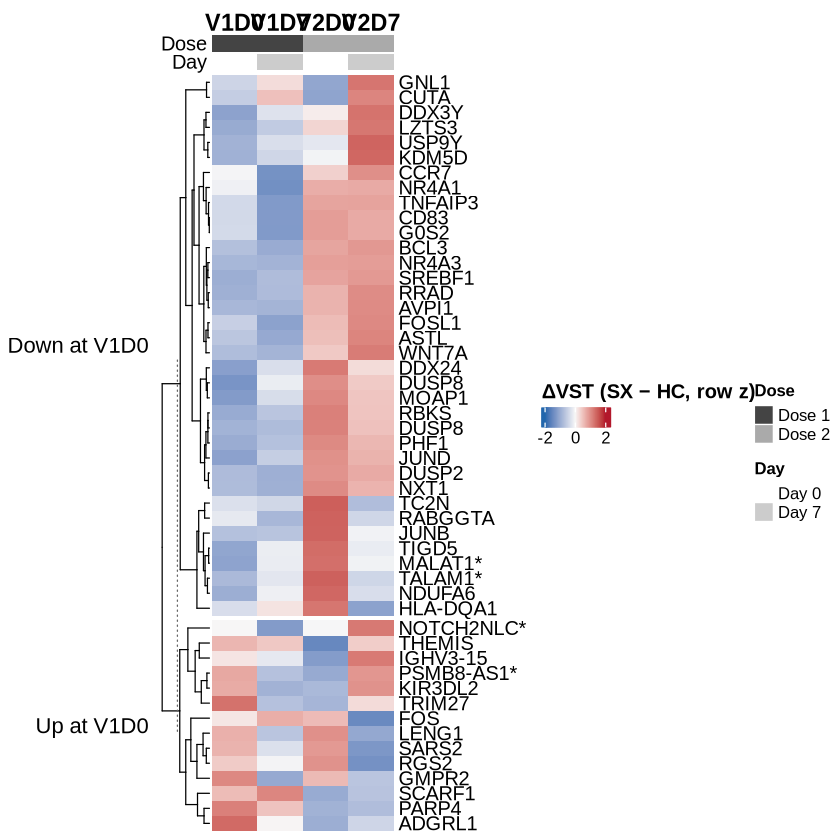

In [5]:
ht_top50